In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
df = pd.read_csv(r"D:\Bank transactions.csv")
df

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,1/1/2010 0:01,1556,2972,($77.00),Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,1/1/2010 0:02,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,1/1/2010 0:02,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,1/1/2010 0:05,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,1/1/2010 0:06,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1048367,8733147,11/6/2010 13:23,1696,2408,($100.00),Swipe Transaction,59935,Merritt Island,FL,32953.0,5499,NaN
1048368,8733148,11/6/2010 13:24,4,5391,$137.61,Swipe Transaction,13523,Seattle,WA,98136.0,5310,NaN
1048369,8733149,11/6/2010 13:24,428,3842,$6.12,Swipe Transaction,38959,Elkhart,KS,67950.0,5921,NaN
1048370,8733150,11/6/2010 13:24,711,4689,$80.00,Swipe Transaction,27092,Belleville,IL,62221.0,4829,NaN


In [64]:
df.dtypes

id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

In [65]:
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y %H:%M", errors="coerce")

In [66]:
df["amount"] = (
    df["amount"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.replace(" ", "", regex=False)
    .str.replace(r"\((.*)\)", r"-\1", regex=True)
    .astype(float)
)

In [67]:
df.dtypes

id                         int64
date              datetime64[ns]
client_id                  int64
card_id                    int64
amount                   float64
use_chip                  object
merchant_id                int64
merchant_city             object
merchant_state            object
zip                      float64
mcc                        int64
errors                    object
dtype: object

In [68]:
# 1) create derived time features (memory-aware)
# assumes df['date'] is already datetime64[ns] and contains no NaT
import numpy as np

# Basic splits
df['transaction_date'] = df['date'].dt.date                # python date object (can be used for grouping)
df['transaction_time'] = df['date'].dt.time                # python time object

# Numeric/time parts (fast for grouping/aggregations)
df['year'] = df['date'].dt.year.astype('int16')            # years 2010-2019 -> int16 saves memory
df['month'] = df['date'].dt.month.astype('uint8')          # 1-12
df['day'] = df['date'].dt.day.astype('uint8')              # 1-31
df['hour'] = df['date'].dt.hour.astype('uint8')            # 0-23
df['minute'] = df['date'].dt.minute.astype('uint8')        # 0-59 (optional; useful if you need minute-level analysis)
# weekday as human string and as numeric
df['weekday'] = df['date'].dt.day_name()                   
df['weekday_num'] = df['date'].dt.weekday.astype('uint8')  # Monday=0 .. Sunday=6

# ISO week / quarter if you need them
# .dt.isocalendar() returns a DataFrame in newer pandas versions
iso = df['date'].dt.isocalendar()
df['iso_year'] = iso['year'].astype('int16')
df['iso_week'] = iso['week'].astype('uint8')

df['quarter'] = df['date'].dt.quarter.astype('uint8')

# Useful flags
df['is_weekend'] = (df['weekday_num'] >= 5).astype('uint8')  # 1 if Sat/Sun, else 0

# Convert low-cardinality string fields to category to save memory
df['weekday'] = df['weekday'].astype('category')

# Quick sanity/head check
print("Sample derived features:")
display(df.loc[:, ['date','transaction_date','transaction_time','year','month','day','hour','weekday','is_weekend']].head(6))

# Show memory usage before/after for these new columns
print("\nMemory usage for new cols (bytes):")
print(df[['year','month','day','hour','weekday_num','iso_week','quarter','is_weekend']].memory_usage(deep=True))

Sample derived features:


,date,transaction_date,transaction_time,year,month,day,hour,weekday,is_weekend
0,2010-01-01 00:01:00,2010-01-01,00:01:00,2010,1,1,0,Friday,0
1,2010-01-01 00:02:00,2010-01-01,00:02:00,2010,1,1,0,Friday,0
2,2010-01-01 00:02:00,2010-01-01,00:02:00,2010,1,1,0,Friday,0
3,2010-01-01 00:05:00,2010-01-01,00:05:00,2010,1,1,0,Friday,0
4,2010-01-01 00:06:00,2010-01-01,00:06:00,2010,1,1,0,Friday,0
5,2010-01-01 00:07:00,2010-01-01,00:07:00,2010,1,1,0,Friday,0



Memory usage for new cols (bytes):
Index              132
year           2096744
month          1048372
day            1048372
hour           1048372
weekday_num    1048372
iso_week       1048372
quarter        1048372
is_weekend     1048372
dtype: int64


In [69]:
print(df['amount'].describe())

count    1.048372e+06
mean     4.377444e+01
std      8.533345e+01
min     -5.000000e+02
25%      9.030000e+00
50%      2.955000e+01
75%      6.527000e+01
max      6.820200e+03
Name: amount, dtype: float64


In [70]:
df['merchant_state'] = df['merchant_state'].fillna("UNKNOWN")

In [71]:
# Remove decimals AND non-numeric characters
df['zip'] = (
    df['zip']
    .astype(str)
    .str.extract(r'(\d+)')       # keep only digits
    .astype('Int64')             # convert to nullable integer
)

In [72]:
df['zip'] = df['zip'].astype('Int64').astype(str).str.zfill(5)

In [73]:
df['merchant_city'].value_counts().head(10)
df['merchant_state'].value_counts().head(10)
df['merchant_id'].value_counts().head(10)
# Identify hotspots

merchant_id
59935    49490
27092    47900
61195    45329
39021    29849
43293    29801
22204    27739
14528    25301
60569    24271
50783    23520
75781    21279
Name: count, dtype: int64

In [74]:
df['use_chip'].value_counts()
# Detect any fraud in swipe and online

use_chip
Swipe Transaction     934123
Online Transaction    114249
Name: count, dtype: int64

In [75]:
df[df['use_chip'] == 'Online Transaction']['errors'].value_counts().head(10)
# Online transactions with errors: insufficient balance, declined, fraud

errors
Insufficient Balance                    852
Bad Card Number                         561
Bad CVV                                 488
Bad Expiration                          429
Technical Glitch                        245
Bad Card Number,Insufficient Balance      9
Bad Expiration,Technical Glitch           3
Bad Card Number,Bad CVV                   3
Bad Card Number,Bad Expiration            2
Bad Expiration,Insufficient Balance       2
Name: count, dtype: int64

In [76]:
df[(df['use_chip'] == 'Swipe Transaction') & (df['amount'] > 500)].sort_values('amount', ascending=False).head(20)
# Swipe transactions with high amount: possibly fraudsters

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,month,day,hour,minute,weekday,weekday_num,iso_year,iso_week,quarter,is_weekend
892174,8544734,2010-09-22 06:37:00,708,5165,6820.20,Swipe Transaction,34524,Staten Island,NY,10302,...,9,22,6,37,Wednesday,2,2010,38,3,0
177166,7686947,2010-02-23 15:22:00,776,5859,4004.73,Swipe Transaction,76639,Memphis,TN,38107,...,2,23,15,22,Tuesday,1,2010,8,1,0
603507,8197899,2010-06-30 10:48:00,708,5165,3424.51,Swipe Transaction,80871,Philadelphia,PA,19114,...,6,30,10,48,Wednesday,2,2010,26,2,0
465395,8032429,2010-05-20 16:58:00,1487,5978,3271.94,Swipe Transaction,89590,Cranberry Twp,PA,16066,...,5,20,16,58,Thursday,3,2010,20,2,0
272172,7800817,2010-03-24 09:44:00,708,5165,2823.72,Swipe Transaction,47203,Louisville,AL,36048,...,3,24,9,44,Wednesday,2,2010,12,1,0
344122,7886860,2010-04-14 16:24:00,1487,4946,2785.80,Swipe Transaction,89590,Cranberry Twp,PA,16066,...,4,14,16,24,Wednesday,2,2010,15,2,0
272119,7800749,2010-03-24 09:30:00,708,5165,2721.96,Swipe Transaction,47203,Louisville,AL,36048,...,3,24,9,30,Wednesday,2,2010,12,1,0
35180,7517440,2010-01-11 16:50:00,1487,4946,2680.80,Swipe Transaction,34378,Mars,PA,16046,...,1,11,16,50,Monday,0,2010,2,1,0
640141,8241647,2010-07-11 07:13:00,708,5165,2557.61,Swipe Transaction,45992,Newport News,VA,23605,...,7,11,7,13,Sunday,6,2010,27,3,1
498184,8071724,2010-05-30 15:13:00,776,5859,2513.34,Swipe Transaction,91816,Memphis,TN,38103,...,5,30,15,13,Sunday,6,2010,21,2,1


In [77]:
df.groupby(['client_id', 'use_chip'])['errors'].apply(lambda x: (x != '').sum()).sort_values(ascending=False).head(10)
# Multiple failed attempts before success: fraud flag

client_id  use_chip         
1098       Swipe Transaction    4132
909        Swipe Transaction    3449
1888       Swipe Transaction    3359
96         Swipe Transaction    3280
114        Swipe Transaction    2908
285        Swipe Transaction    2701
1776       Swipe Transaction    2602
208        Swipe Transaction    2457
1559       Swipe Transaction    2404
1727       Swipe Transaction    2305
Name: errors, dtype: int64

In [78]:
df[df['errors'] != ''].groupby('merchant_id')['errors'].count().sort_values(ascending=False).head(10)
# Merchants with unusually high declines

merchant_id
27092    1471
59935     880
61195     672
39021     582
43293     493
60569     487
22204     469
26810     287
50783     269
20561     249
Name: errors, dtype: int64

In [79]:
failed_attempts = (
    df[df['errors'] != '']
    .groupby('client_id')['errors']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

failed_attempts
# Top 10 clients with frequent declines, insufficient balance, fraud flags, etc

client_id
954     240
1888    159
464     105
1098     94
363      92
1696     91
1382     83
1424     78
96       68
1885     67
Name: errors, dtype: int64

In [80]:
# create full datetime without copying
df['full_datetime'] = pd.to_datetime(
    df['transaction_date'].astype(str) + ' ' + df['transaction_time'].astype(str)
)

# keep only needed columns to reduce memory
cols = ['client_id', 'merchant_state', 'full_datetime']
df_small = df[cols]

# sort only the small df
df_small = df_small.sort_values(['client_id', 'full_datetime'])

df_small['prev_state'] = df_small.groupby('client_id')['merchant_state'].shift()
df_small['prev_time'] = df_small.groupby('client_id')['full_datetime'].shift()

df_small['time_diff'] = df_small['full_datetime'] - df_small['prev_time']

suspicious_travel = df_small[
    (df_small['merchant_state'] != df_small['prev_state']) &
    (df_small['time_diff'].dt.total_seconds() < 1800)
]

suspicious_travel.head()
# Same client spending in different states within 30 minutes

,client_id,merchant_state,full_datetime,prev_state,prev_time,time_diff
11584,0,ME,2010-01-04 13:19:00,UNKNOWN,2010-01-04 13:03:00,0 days 00:16:00
28007,0,MA,2010-01-09 14:50:00,NV,2010-01-09 14:36:00,0 days 00:14:00
146412,0,UNKNOWN,2010-02-14 13:05:00,ME,2010-02-14 12:49:00,0 days 00:16:00
244142,0,MI,2010-03-15 19:25:00,UNKNOWN,2010-03-15 19:23:00,0 days 00:02:00
256330,0,ME,2010-03-19 13:51:00,MI,2010-03-19 13:42:00,0 days 00:09:00


In [81]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract weekday and hour
df['weekday'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour

# Build pivot heatmap-friendly table
pivot = df.pivot_table(
    index='weekday',
    columns='hour',
    values='id',
    aggfunc='count'
).fillna(0)

pivot.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
Friday,1516,1272,1229,1157,1239,1974,6899,8592,8240,8171,...,9906,9700,9408,5504,5656,5407,5176,5081,5101,1769
Monday,1569,1299,1346,1179,1343,2142,9175,10767,10403,10490,...,10143,9723,9828,5372,5014,4957,4703,4529,4561,1735
Saturday,1568,1375,1161,1157,1227,1922,7003,8599,8226,7958,...,10010,9529,9534,5854,5749,5453,5173,5215,5357,1861
Sunday,1606,1286,1400,1194,1247,2222,9174,10618,10479,10390,...,9950,9725,9813,5520,5233,5129,4592,4728,4643,1815
Thursday,1581,1291,1444,1227,1341,2108,9052,10885,10444,10266,...,10113,9841,9890,5516,5330,5163,4771,4845,4713,1964


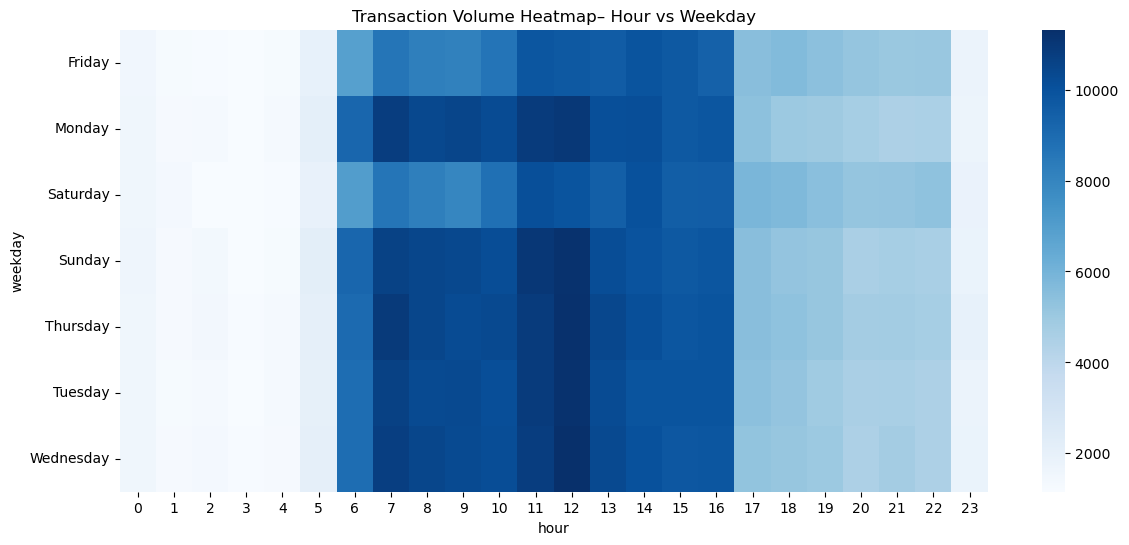

In [82]:
plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="Blues")
plt.title("Transaction Volume Heatmap– Hour vs Weekday")
plt.show()

In [83]:
hourly = df.pivot_table(
    index='hour',
    columns='use_chip',
    values='id',
    aggfunc='count'
).fillna(0)

hourly

use_chip,Online Transaction,Swipe Transaction
hour,,
0,2091,8914
1,1479,7590
2,1344,7959
3,941,7363
4,1788,7265
5,1900,12608
6,6285,52850
7,7544,63344
8,6239,62304


In [84]:
hourly_pct = hourly.div(hourly.sum(axis=1), axis=0) * 100
hourly_pct

use_chip,Online Transaction,Swipe Transaction
hour,,
0,19.000454,80.999546
1,16.308303,83.691697
2,14.446953,85.553047
3,11.331888,88.668112
4,19.750359,80.249641
5,13.096223,86.903777
6,10.628224,89.371776
7,10.642140,89.357860
8,9.102315,90.897685


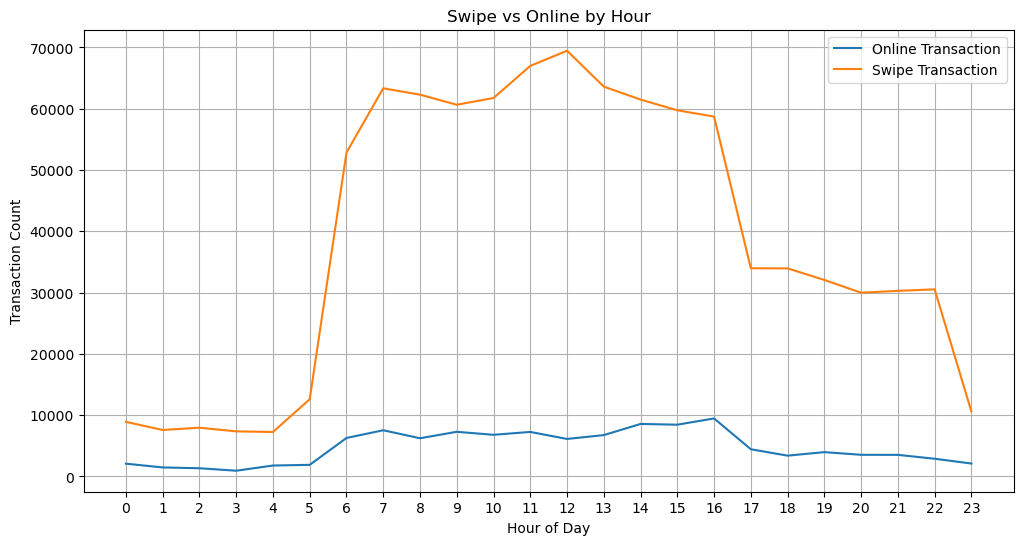

In [85]:
plt.figure(figsize=(12,6))
for method in hourly.columns:
    plt.plot(hourly.index, hourly[method], label=method)

plt.xticks(range(0,24))
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.title("Swipe vs Online by Hour")
plt.legend()
plt.grid(True)
plt.show()

In [86]:
zip_counts = df.groupby('zip')['id'].count().sort_values(ascending=False)
zip_counts.head(20)

zip
0<NA>    120415
98516      3078
87121      2646
91606      2449
95687      2305
80013      2254
77056      2201
29229      2164
94606      2129
30101      2042
43830      2042
10463      1938
55024      1921
43228      1911
85711      1785
96792      1737
11211      1656
92886      1640
38606      1608
40299      1604
Name: id, dtype: int64

In [87]:
df['amount_numeric'] = (
    df['amount'].astype(str)
        .str.replace('[\$,]', '', regex=True)
        .astype(float)
)

zip_stats = df.groupby('zip').agg(
    transactions=('id', 'count'),
    total_amount=('amount_numeric', 'sum'),
    avg_ticket=('amount_numeric', 'mean'),
)

zip_stats.sort_values('transactions', ascending=False).head(20)

,transactions,total_amount,avg_ticket
zip,,,
0<NA>,120415,6989152.17,58.042205
98516,3078,47142.35,15.315903
87121,2646,52797.36,19.953651
91606,2449,52112.21,21.278975
95687,2305,71889.78,31.188625
80013,2254,70667.86,31.352201
77056,2201,61444.53,27.916642
29229,2164,42845.51,19.799219
94606,2129,117695.63,55.282118


In [88]:
refunds = df[df['amount_numeric'] < 0]
hot_refund_zips = refunds.groupby('zip')['id'].count().sort_values(ascending=False)

hot_refund_zips.head(20)

zip
0<NA>    1457
98516     718
29229     570
43830     564
77056     526
91606     521
55024     517
94606     464
07922     456
96792     370
51023     368
89148     365
51022     349
87121     349
48146     348
80013     328
67212     324
19146     295
18011     293
45013     286
Name: id, dtype: int64

In [89]:
fraud_index = pd.DataFrame({
    'transactions': zip_counts,
    'refunds': hot_refund_zips
}).fillna(0)

fraud_index['refund_rate'] = fraud_index['refunds'] / fraud_index['transactions']
fraud_index.sort_values('refund_rate', ascending=False).head(20)

,transactions,refunds,refund_rate
zip,,,
11971,2,1.0,0.500000
14548,2,1.0,0.500000
18708,2,1.0,0.500000
53543,2,1.0,0.500000
33141,2,1.0,0.500000
67117,2,1.0,0.500000
24340,2,1.0,0.500000
02780,2,1.0,0.500000
75220,5,2.0,0.400000


In [90]:
import plotly.express as px
import plotly.graph_objects as go

# Ensure transaction_date is datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Aggregate by month
monthly_summary = df.groupby(df['transaction_date'].dt.to_period('M')).agg({
    'amount': 'sum',        # total transaction value
    'transaction_date': 'count'  # transaction count
}).rename(columns={'transaction_date': 'transaction_count'}).reset_index()

# Convert Period to datetime for plotting
monthly_summary['transaction_date'] = monthly_summary['transaction_date'].dt.to_timestamp()

# Line chart for total transaction value
fig_value = px.line(
    monthly_summary,
    x='transaction_date',
    y='amount',
    title='Monthly Transaction Value',
    labels={'transaction_date': 'Month', 'amount': 'Total Transaction Value'}
)
fig_value.show()

# Line chart for transaction count
fig_count = px.line(
    monthly_summary,
    x='transaction_date',
    y='transaction_count',
    title='Monthly Transaction Count',
    labels={'transaction_date': 'Month', 'transaction_count': 'Number of Transactions'}
)
fig_count.show()

In [91]:
# Ensure amount is numeric
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

# Aggregate transaction value by customer
customer_summary = df.groupby('client_id')['amount'].sum().reset_index()

# Sort customers by transaction value descending
customer_summary = customer_summary.sort_values(by='amount', ascending=False)

# Calculate cumulative percentage of total
customer_summary['cum_percent'] = customer_summary['amount'].cumsum() / customer_summary['amount'].sum() * 100

# Pareto chart: bars for individual customer contribution, line for cumulative %
fig = go.Figure()

# Bar trace: transaction value per customer
fig.add_trace(go.Bar(
    x=customer_summary['client_id'],
    y=customer_summary['amount'],
    name='Transaction Value'
))

# Line trace: cumulative %
fig.add_trace(go.Scatter(
    x=customer_summary['client_id'],
    y=customer_summary['cum_percent'],
    name='Cumulative %',
    yaxis='y2',
    mode='lines+markers',
    line=dict(color='red', width=2)
))

# Layout with dual y-axis
fig.update_layout(
    title='Pareto Chart: Transaction Value by Customer',
    xaxis_title='Client ID',
    yaxis=dict(title='Transaction Value'),
    yaxis2=dict(title='Cumulative %', overlaying='y', side='right', range=[0, 110]),
    legend=dict(x=0.75, y=1.15)
)

fig.show()

In [92]:
# Aggregate transaction value by city
city_summary = df.groupby('merchant_city')['amount'].sum().reset_index()

# Choropleth heatmap by US state (if using state)
state_summary = df.groupby('merchant_state')['amount'].sum().reset_index()

# Choropleth by state (requires valid US state codes)
fig_state = px.choropleth(
    state_summary,
    locations='merchant_state',
    locationmode='USA-states',
    color='amount',
    color_continuous_scale='Reds',
    title='Transaction Value by State'
)
fig_state.show()

In [93]:
# Count number of transactions per channel
channel_summary = df['use_chip'].value_counts().reset_index()
channel_summary.columns = ['channel', 'count']
# Donut chart (same as pie, but with hole in the center)
fig_donut = px.pie(
    channel_summary,
    names='channel',
    values='count',
    hole=0.4,
    title='Transaction Distribution by Channel'
)
fig_donut.show()

In [94]:
# Create approval_status based on errors column
df['approval_status'] = df['errors'].apply(lambda x: 'Rejected' if pd.notnull(x) else 'Approved')

In [95]:
# Sample preprocessing: ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Aggregate counts by day (or month)
approval_summary = df.groupby([df['date'].dt.to_period('M'), 'approval_status']).size().unstack(fill_value=0).reset_index()
approval_summary['date'] = approval_summary['date'].dt.to_timestamp()  # convert period to datetime

# Create waterfall chart
fig = go.Figure(go.Waterfall(
    name="Approval vs Rejection",
    x=approval_summary['date'],
    y=approval_summary['Approved'],  # Positive flow
    text=approval_summary['Approved'],
    textposition="outside",
    measure=["relative"] * len(approval_summary),  # relative for each bar
))

# Add rejected as negative values
fig.add_trace(go.Bar(
    x=approval_summary['date'],
    y=-approval_summary['Rejected'],
    name='Rejected',
    marker_color='red'
))

# Update layout
fig.update_layout(
    title="Monthly Approvals vs Rejections",
    xaxis_title="Month",
    yaxis_title="Number of Transactions",
    showlegend=True
)

fig.show()

In [96]:
# Example: flag anomalies
df['anomaly_high_amount'] = df['amount'].abs() > 1000          # high transaction amount
df['anomaly_high_freq'] = df.groupby('client_id')['id'].transform('count') > 20  # high frequency
df['anomaly_location'] = df['merchant_state'].isin(['ND', 'AK'])  # unusual locations (example)

# Combine anomaly flags
df['anomaly_flag'] = df[['anomaly_high_amount','anomaly_high_freq','anomaly_location']].any(axis=1)

# KPI values
total_anomalies = df['anomaly_flag'].sum()
percent_high_risk = df['anomaly_flag'].mean() * 100

# Count top reasons
reason_counts = pd.DataFrame({
    'Reason': ['High Amount', 'High Frequency', 'Unusual Location'],
    'Count': [
        df['anomaly_high_amount'].sum(),
        df['anomaly_high_freq'].sum(),
        df['anomaly_location'].sum()
    ]
})

In [97]:
# Total anomalies gauge
fig_gauge_total = go.Figure(go.Indicator(
    mode="number+gauge",
    value=total_anomalies,
    title={"text": "Total Anomalies Detected"},
    gauge={"axis": {"range": [0, df.shape[0]]}, "bar": {"color": "red"}}
))
fig_gauge_total.show()

# Percentage of high-risk transactions
fig_gauge_percent = go.Figure(go.Indicator(
    mode="gauge+number",
    value=percent_high_risk,
    title={"text": "% of High-Risk Transactions"},
    gauge={"axis": {"range": [0, 100]}, "bar": {"color": "orange"}}
))
fig_gauge_percent.show()


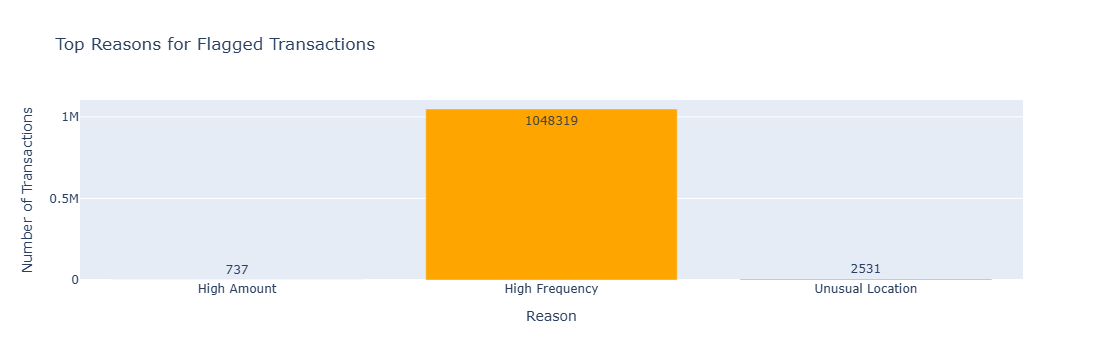

In [98]:
fig_bar = go.Figure(go.Bar(
    x=reason_counts['Reason'],
    y=reason_counts['Count'],
    text=reason_counts['Count'],
    textposition='auto',
    marker_color=['red', 'orange', 'purple']
))

fig_bar.update_layout(
    title="Top Reasons for Flagged Transactions",
    xaxis_title="Reason",
    yaxis_title="Number of Transactions"
)
fig_bar.show()

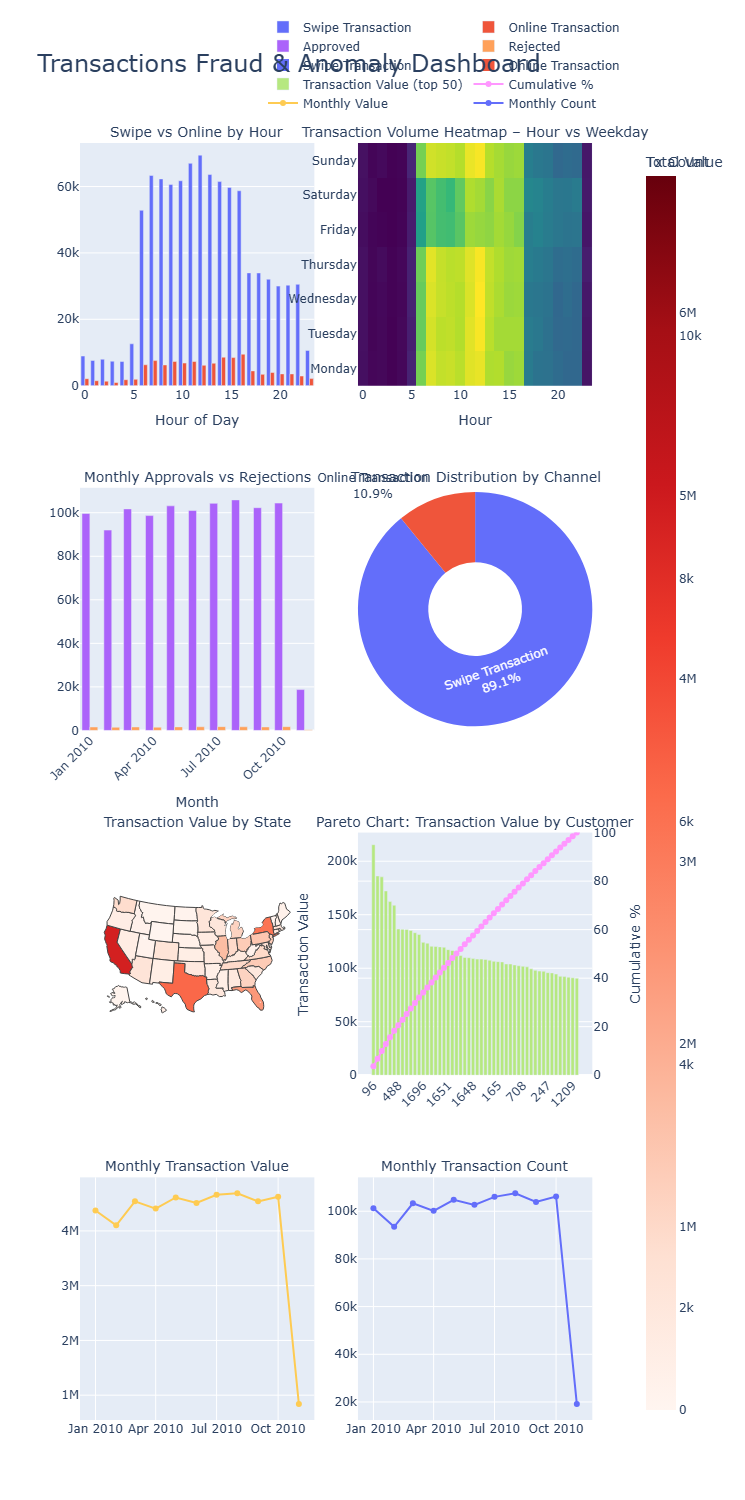

In [99]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# --- Data cleaning & standard fields (idempotent) ---
# Clean amount
df['amount'] = df['amount'].astype(str).str.replace(r"[\$,]", "", regex=True)
df['amount'] = df['amount'].str.replace(r"\((.*)\)", r"-\1", regex=True).astype(float)

# Parse datetime fields
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

# Approval status from errors
df['approval_status'] = df['errors'].apply(lambda x: 'Rejected' if pd.notnull(x) else 'Approved')

# Example anomaly flags (keeps same logic used earlier)
df['anomaly_high_amount'] = df['amount'].abs() > 1000
df['anomaly_high_freq'] = df.groupby('client_id')['id'].transform('count') > 20
df['anomaly_location'] = df['merchant_state'].isin(['ND','AK'])
df['anomaly_flag'] = df[['anomaly_high_amount','anomaly_high_freq','anomaly_location']].any(axis=1)

# --- Aggregations used by charts ---
# 1. Swipe vs Online by Hour
hour_channel = df.groupby(['hour','use_chip']).size().unstack(fill_value=0).sort_index()

# detect swipe/online column names robustly
def find_col(cols, keywords):
    for kw in keywords:
        for c in cols:
            if kw.lower() in str(c).lower():
                return c
    return None

swipe_col = find_col(hour_channel.columns, ['swipe', 'chip'])      # e.g., "Swipe Transaction"
online_col = find_col(hour_channel.columns, ['online', 'web', 'e-'])  # e.g., "Online Transaction"

# 2. Transaction Volume Heatmap – Hour vs Weekday
heatmap_data = df.groupby(['weekday','hour']).size().unstack(fill_value=0)
weekdays_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
heatmap_data = heatmap_data.reindex(weekdays_order).fillna(0)

# 3. Monthly Approvals vs Rejections
approval_summary = df.groupby([df['month'], 'approval_status']).size().unstack(fill_value=0)

# 4. Transaction Distribution by Channel
channel_summary = df['use_chip'].value_counts().reset_index()
channel_summary.columns = ['channel','count']

# 5. Transaction Value by State
state_summary = df.groupby('merchant_state')['amount'].sum().reset_index()

# 6. Pareto Chart: Transaction Value by Customer
customer_summary = df.groupby('client_id')['amount'].sum().sort_values(ascending=False)
customer_summary_cumsum = (customer_summary.cumsum() / customer_summary.sum()) * 100
# keep only top N customers for readability (you can change N)
TOP_N = 50
cust_top = customer_summary.head(TOP_N)
cust_top_pct = (cust_top.cumsum() / cust_top.sum()) * 100

# 7. Monthly Transaction Value & Count
monthly_value = df.groupby('month')['amount'].sum().sort_index()
monthly_count = df.groupby('month')['id'].count().sort_index()

# --- Build subplots in the requested order ---
# Layout: 4 rows x 2 cols -> 8 charts (order follows user list)
specs = [
    [{"type":"xy"},      {"type":"heatmap"}],        # Row1: Swipe vs Online by Hour | Heatmap Hour vs Weekday
    [{"type":"bar"},     {"type":"pie"}],            # Row2: Monthly Approvals vs Rejections | Transaction Distribution by Channel
    [{"type":"choropleth"},{"type":"xy", "secondary_y": True}],  # Row3: Transaction Value by State | Pareto (secondary_y)
    [{"type":"xy"},      {"type":"xy"}]              # Row4: Monthly Transaction Value | Monthly Transaction Count
]

subplot_titles = [
    "Swipe vs Online by Hour",
    "Transaction Volume Heatmap – Hour vs Weekday",
    "Monthly Approvals vs Rejections",
    "Transaction Distribution by Channel",
    "Transaction Value by State",
    "Pareto Chart: Transaction Value by Customer",
    "Monthly Transaction Value",
    "Monthly Transaction Count"
]

fig = make_subplots(
    rows=4, cols=2,
    specs=specs,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.08,
    vertical_spacing=0.08
)

# -------------------------
# Row1 Col1: Swipe vs Online by Hour (grouped bars)
# -------------------------
hours = hour_channel.index
# fallback to zero series if column not found
swipe_vals = hour_channel[swipe_col] if swipe_col in hour_channel.columns else pd.Series(0, index=hours)
online_vals = hour_channel[online_col] if online_col in hour_channel.columns else pd.Series(0, index=hours)

fig.add_trace(go.Bar(x=hours, y=swipe_vals, name=str(swipe_col or 'Swipe')), row=1, col=1)
fig.add_trace(go.Bar(x=hours, y=online_vals, name=str(online_col or 'Online')), row=1, col=1)

# -------------------------
# Row1 Col2: Transaction Volume Heatmap – Hour vs Weekday
# -------------------------
fig.add_trace(go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns.astype(int),
    y=heatmap_data.index,
    colorscale='Viridis',
    colorbar=dict(title='Tx Count')
), row=1, col=2)

# -------------------------
# Row2 Col1: Monthly Approvals vs Rejections (grouped bar)
# -------------------------
# ensure index is sorted
approval_idx = approval_summary.index
approved_vals = approval_summary.get('Approved', pd.Series(0, index=approval_idx))
rejected_vals = approval_summary.get('Rejected', pd.Series(0, index=approval_idx))

fig.add_trace(go.Bar(x=approval_idx, y=approved_vals, name='Approved'), row=2, col=1)
fig.add_trace(go.Bar(x=approval_idx, y=rejected_vals, name='Rejected'), row=2, col=1)

# -------------------------
# Row2 Col2: Transaction Distribution by Channel (donut)
# -------------------------
fig.add_trace(go.Pie(labels=channel_summary['channel'], values=channel_summary['count'], hole=0.4, textinfo='percent+label'), row=2, col=2)

# -------------------------
# Row3 Col1: Transaction Value by State (choropleth)
# -------------------------
fig.add_trace(go.Choropleth(
    locations=state_summary['merchant_state'],
    locationmode='USA-states',
    z=state_summary['amount'],
    colorscale='Reds',
    colorbar=dict(title='Total Value')
), row=3, col=1)

# -------------------------
# Row3 Col2: Pareto Chart: Transaction Value by Customer (bar + cumulative line, secondary y)
# -------------------------
# Bar for top customers
fig.add_trace(go.Bar(x=cust_top.index.astype(str), y=cust_top.values, name='Transaction Value (top {})'.format(TOP_N)), row=3, col=2, secondary_y=False)
# Line for cumulative percent (mapped to secondary y)
fig.add_trace(go.Scatter(x=cust_top.index.astype(str), y=cust_top_pct.values, name='Cumulative %', mode='lines+markers'), row=3, col=2, secondary_y=True)

# -------------------------
# Row4 Col1: Monthly Transaction Value (line)
# -------------------------
fig.add_trace(go.Scatter(x=monthly_value.index, y=monthly_value.values, mode='lines+markers', name='Monthly Value'), row=4, col=1)

# -------------------------
# Row4 Col2: Monthly Transaction Count (line)
# -------------------------
fig.add_trace(go.Scatter(x=monthly_count.index, y=monthly_count.values, mode='lines+markers', name='Monthly Count'), row=4, col=2)

# -------------------------
# Layout adjustments for readability
# -------------------------
fig.update_layout(
    height=1500,
    width=2200,                # increased width for readability
    title_text="Transactions Fraud & Anomaly Dashboard",
    title_font_size=24,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# enlarge subplot titles
for ann in fig['layout']['annotations']:
    ann['font'] = dict(size=14)

# rotate pareto x-ticks for readability and limit shown ticks if many customers
fig.update_xaxes(row=3, col=2, tickangle=-45)
# If there are many top customers, show fewer ticks
fig.update_xaxes(tickmode='auto', nticks=10, row=3, col=2)

# set x-axis label for hour plots
fig.update_xaxes(title_text='Hour of Day', row=1, col=1)
fig.update_xaxes(title_text='Hour', row=1, col=2)

# For approval chart, format x tick labels (months)
fig.update_xaxes(title_text='Month', row=2, col=1)
fig.update_xaxes(tickangle=-45, row=2, col=1)

# Pareto secondary y-axis settings (percentage 0-100)
fig.update_yaxes(title_text='Transaction Value', row=3, col=2, secondary_y=False)
fig.update_yaxes(title_text='Cumulative %', range=[0,100], row=3, col=2, secondary_y=True)

# Improve choropleth layout region (zoom-ish)
fig.update_geos(scope='usa', row=3, col=1)

# show
fig.show()